<a href="https://colab.research.google.com/github/bibinjose/WQU_capstone/blob/main/VaR_and_ES_in_Commodities_with_fx_exposure_(BRL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Value-at-Risk (VaR) and Expected Shortfall (ES) in Commodities

Producer CFaR / VaR–ES Risk Engine

Sample portfolio for an Brazil farmer with Corn Soybean Wheat commodities. Now not taking Basis and freight into account.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import t as student_t, jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
from numpy.linalg import eigh, cholesky

TICKERS = ["ZC=F", "ZS=F", "ZW=F"]
START = "2014-01-01"
END = None
USE_BASIS = False
BASIS_USD_PER_BU = {
    "ZC=F": 0.00,
    "ZS=F": 0.00,
    "ZW=F": 0.00,
}

# for portfolio taking 1M bushels for Corn Soybean & Wheat
EXPOSURE_BUSHELS = {"ZC=F": 1_000_000, "ZS=F": 1_000_000, "ZW=F": 1_000_000}

HORIZON_DAYS = 20
N_PATHS = 25_000
DIST = "student_t"
T_DF = 6
CONF_VAR = 0.99
CONF_ES = 0.975
CFAR_TARGET_FRACTION = 0.20
FUT_CONTRACT_SIZE = 5_000.0


data = yf.download(TICKERS, start=START, end=END, progress=False)
prices_fut = data["Close"].dropna(how="all")  # $/bu
if isinstance(prices_fut, pd.Series):
    prices_fut = prices_fut.to_frame()

if USE_BASIS:
    basis = pd.DataFrame({t: BASIS_USD_PER_BU.get(t, 0.0) for t in TICKERS}, index=prices_fut.index)
    prices_cash = (prices_fut + basis).dropna(how="any", axis=0)
else:
    prices_cash = prices_fut.copy()

returns = np.log(prices_fut / prices_fut.shift(1)).dropna()


print("LAST PRICES (cash) USD/bu")
print(prices_cash.iloc[-1].round(4))


/tmp/ipython-input-1136371927.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKERS, start=START, end=END, progress=False)


LAST PRICES (cash) USD/bu
Ticker
ZC=F     423.00
ZS=F    1037.75
ZW=F     504.50
Name: 2025-10-17 00:00:00, dtype: float64


In [2]:
print("DESCRIPTIVE STATS (daily log returns x 1e2 %)")
desc = (returns * 100).describe().T
desc["skew"] = (returns * 100).skew()
desc["kurtosis_excess"] = (returns * 100).kurtosis()
print(desc.round(3))

DESCRIPTIVE STATS (daily log returns x 1e2 %)
         count   mean    std     min    25%    50%    75%     max   skew  \
Ticker                                                                     
ZC=F    2962.0 -0.000  1.601 -19.100 -0.866  0.000  0.878   7.718 -1.244   
ZS=F    2962.0 -0.007  1.325 -11.092 -0.750  0.036  0.736   6.426 -0.840   
ZW=F    2962.0 -0.005  1.949 -11.297 -1.215 -0.059  1.114  19.701  0.510   

        kurtosis_excess  
Ticker                   
ZC=F             15.804  
ZS=F              7.025  
ZW=F              5.100  


In [3]:
print("NORMALITY: Jarque–Bera p-values")
jb_rows = []
for c in returns.columns:
    stat, p = jarque_bera(returns[c].dropna())
    jb_rows.append((c, p))
print(pd.DataFrame(jb_rows, columns=["asset", "JB_pval"]).set_index("asset").round(4))


NORMALITY: Jarque–Bera p-values
       JB_pval
asset         
ZC=F       0.0
ZS=F       0.0
ZW=F       0.0


In [4]:
print("AUTOCORRELATION (Ljung–Box p-values at lags 5, 20)")
lb_rows = []
for c in returns.columns:
    lb5 = acorr_ljungbox(returns[c].dropna(), lags=[5], return_df=True)["lb_pvalue"].iloc[0]
    lb20 = acorr_ljungbox(returns[c].dropna(), lags=[20], return_df=True)["lb_pvalue"].iloc[0]
    lb_rows.append((c, lb5, lb20))
print(pd.DataFrame(lb_rows, columns=["asset", "LB_p(5)", "LB_p(20)"]).set_index("asset").round(4))


AUTOCORRELATION (Ljung–Box p-values at lags 5, 20)
       LB_p(5)  LB_p(20)
asset                   
ZC=F    0.1690    0.6629
ZS=F    0.0055    0.0090
ZW=F    0.0048    0.0069


In [5]:
print("CORRELATION MATRIX (daily returns)")
print(returns.corr().round(3))

print("ROLLING VOL (21d, annualized %)")
roll_vol = returns.rolling(21).std() * np.sqrt(252) * 100
print(roll_vol.iloc[-1].round(2))




CORRELATION MATRIX (daily returns)
Ticker   ZC=F   ZS=F   ZW=F
Ticker                     
ZC=F    1.000  0.520  0.529
ZS=F    0.520  1.000  0.327
ZW=F    0.529  0.327  1.000
ROLLING VOL (21d, annualized %)
Ticker
ZC=F    12.76
ZS=F    14.99
ZW=F    17.40
Name: 2025-10-17 00:00:00, dtype: float64


In [6]:
print("TAIL CHECK: Empirical vs Gaussian 1% loss (in % return points)")
tail_rows = []
for c in returns.columns:
    r = returns[c].dropna()
    emp_q = np.quantile(r, 0.01) * 100
    mu, sig = r.mean(), r.std()
    gauss_q = (mu + sig * np.quantile(np.random.normal(size=1_000_000), 0.01)) * 100
    tail_rows.append((c, emp_q, gauss_q))
print(pd.DataFrame(tail_rows, columns=["asset", "empirical_1pct", "gaussian_1pct"]).set_index("asset").round(3))

TAIL CHECK: Empirical vs Gaussian 1% loss (in % return points)
       empirical_1pct  gaussian_1pct
asset                               
ZC=F           -4.319         -3.719
ZS=F           -3.486         -3.087
ZW=F           -4.257         -4.554


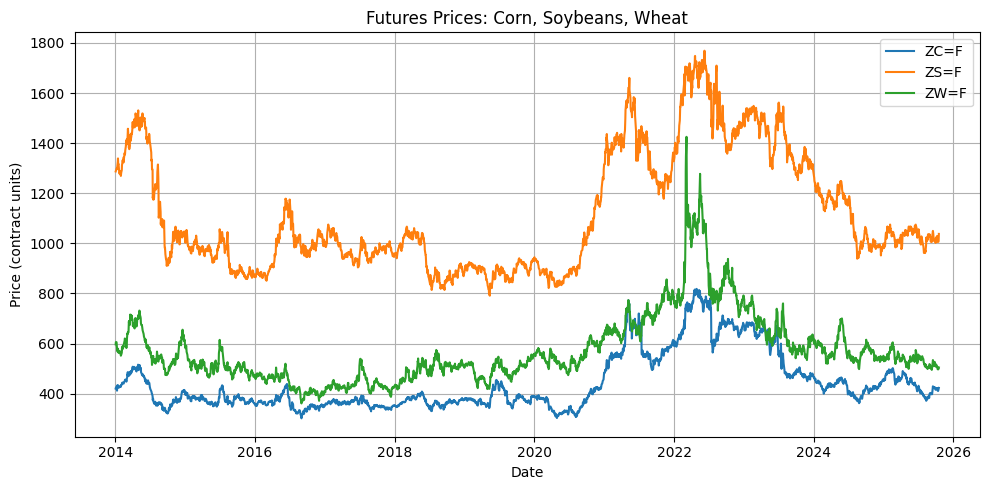

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
for t in TICKERS:
    plt.plot(prices_fut.index, prices_fut[t])
plt.title("Futures Prices: Corn, Soybeans, Wheat")
plt.xlabel("Date")
plt.ylabel("Price (contract units)")
plt.grid(True)
plt.legend(TICKERS)
plt.tight_layout()
plt.show()

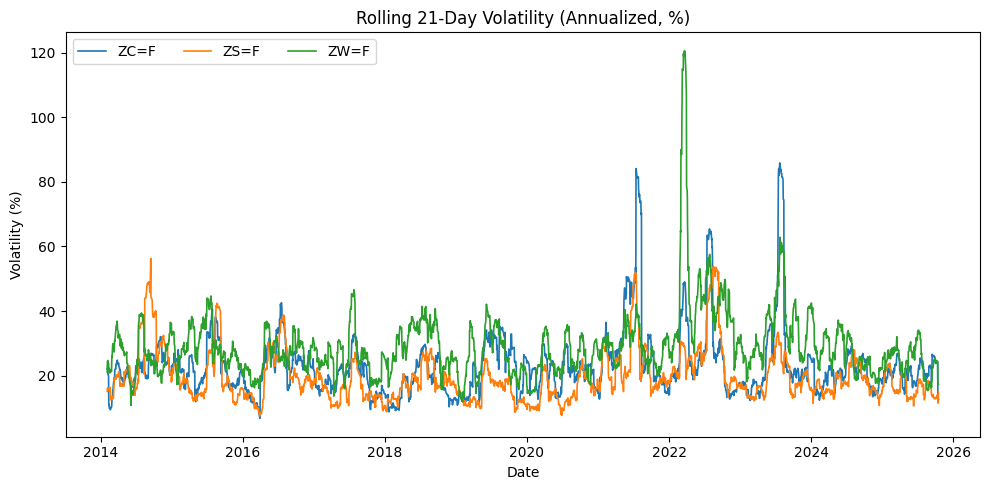

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
rv = returns.rolling(21).std() * (252**0.5) * 100
for c in rv.columns:
    ax.plot(rv.index, rv[c], label=c, linewidth=1.2)
ax.set_title("Rolling 21-Day Volatility (Annualized, %)")
ax.set_xlabel("Date")
ax.set_ylabel("Volatility (%)")
ax.legend(ncol=len(rv.columns))
plt.tight_layout()
plt.show()


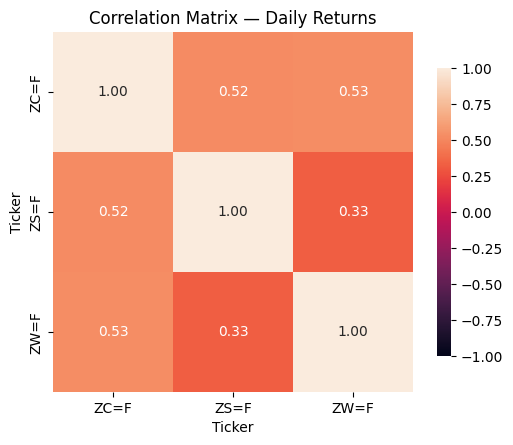

In [9]:
fig, ax = plt.subplots(figsize=(5.5, 4.5))
corr = returns.corr()
sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1, vmax=1, square=True, ax=ax, cbar_kws={"shrink":0.8})
ax.set_title("Correlation Matrix — Daily Returns")
plt.tight_layout()
plt.show()

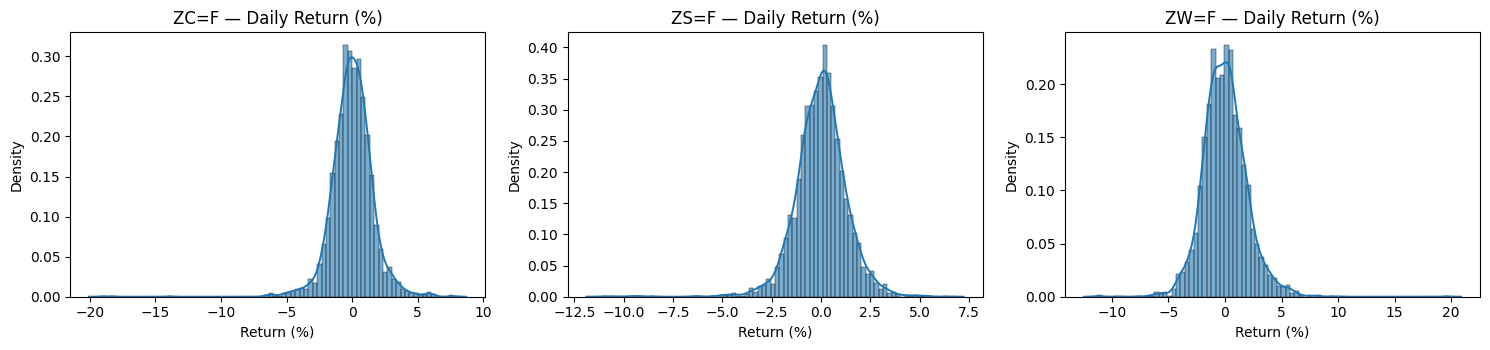

In [10]:
cols = returns.columns.tolist()
n = len(cols)
rows = 1 if n <= 3 else int(np.ceil(n/2))
cols_per_row = min(3, n)
fig, axes = plt.subplots(rows, cols_per_row, figsize=(5*cols_per_row, 3.6*rows))
axes = np.atleast_1d(axes).ravel()

for i, name in enumerate(cols):
    r = returns[name].dropna() * 100  # %
    sns.histplot(r, bins=80, stat="density", ax=axes[i], alpha=0.6)
    sns.kdeplot(r, ax=axes[i], linewidth=1.4)
    axes[i].set_title(f"{name} — Daily Return (%)")
    axes[i].set_xlabel("Return (%)"); axes[i].set_ylabel("Density")
for j in range(i+1, len(axes)):
    axes[j].axis("off")
plt.tight_layout()
plt.show()

In [11]:
mu = returns.mean().values
cov = returns.cov().values

w, V = eigh((cov + cov.T) / 2.0)
w[w < 1e-10] = 1e-10
cov_psd = (V @ np.diag(w) @ V.T)
L = cholesky(cov_psd)

if DIST.lower() == "gaussian":
    Z = np.random.normal(size=(N_PATHS, HORIZON_DAYS, len(mu)))
else:
    g = np.random.gamma(T_DF/2.0, 2.0/T_DF, size=(N_PATHS, HORIZON_DAYS))
    Z = np.random.normal(size=(N_PATHS, HORIZON_DAYS, len(mu))) / np.sqrt(g)[:, :, None]

dR = (Z @ L.T) + mu
R_h = dR.sum(axis=1)

In [12]:
last_cash = prices_cash.iloc[-1]
tickers = list(last_cash.index)
qty_vec = np.array([EXPOSURE_BUSHELS.get(t, 0.0) for t in tickers])

price_end = {}
for i, t in enumerate(tickers):
    price_end[t] = last_cash[t] * np.exp(R_h[:, i])
price_end = pd.DataFrame(price_end)  # paths x assets

start_val = last_cash.values * qty_vec
end_val = price_end.values * qty_vec
pnl_unhedged = (end_val - start_val).sum(axis=1)

alpha_var = 1 - CONF_VAR
q_var = np.quantile(pnl_unhedged, alpha_var)
VaR_u = -q_var
alpha_es = 1 - CONF_ES
q_es = np.quantile(pnl_unhedged, alpha_es)
ES_u = -pnl_unhedged[pnl_unhedged <= q_es].mean()

print("UNHEDGED RISK (USD)")
print({"VaR_%": int(CONF_VAR*100), "VaR_USD": round(VaR_u, 2),
       "ES_%": int(CONF_ES*100), "ES_USD": round(ES_u, 2)})

target_cfar_usd = CFAR_TARGET_FRACTION * VaR_u

sigma_h = R_h.std(axis=0)
risk_notional = last_cash.values * qty_vec
contrib = np.abs(risk_notional * sigma_h)
w_contrib = contrib / (contrib.sum() + 1e-12)

reduction_needed = max(VaR_u - target_cfar_usd, 0.0)
per_asset_reduction = w_contrib * reduction_needed
contract_usd = FUT_CONTRACT_SIZE * prices_fut.iloc[-1].values
hedge_contracts = np.round(per_asset_reduction / (contract_usd + 1e-12)).astype(int)

hedge_series = pd.Series(hedge_contracts, index=tickers)
print("HEDGE CONTRACTS (short futures, + = more short)")
print(hedge_series)

fut_last = prices_fut.iloc[-1]
fut_end = {}
for i, t in enumerate(tickers):
    fut_end[t] = fut_last[t] * np.exp(R_h[:, i])
fut_end = pd.DataFrame(fut_end)

dP = fut_end.values - fut_last.values
mtm = -(dP * (FUT_CONTRACT_SIZE * hedge_contracts))   # short futures MTM
pnl_hedged = pnl_unhedged + mtm.sum(axis=1)

q_var_h = np.quantile(pnl_hedged, alpha_var)
VaR_h = -q_var_h
q_es_h = np.quantile(pnl_hedged, alpha_es)
ES_h = -pnl_hedged[pnl_hedged <= q_es_h].mean()

print("HEDGED RISK (USD)")
print({"VaR_%": int(CONF_VAR*100), "VaR_USD": round(VaR_h, 2),
       "ES_%": int(CONF_ES*100), "ES_USD": round(ES_h, 2),
       "VaR_Reduction_%": round(100*(1 - VaR_h/max(VaR_u,1e-9)), 2)})

UNHEDGED RISK (USD)
{'VaR_%': 99, 'VaR_USD': np.float64(282268821.64), 'ES_%': 97, 'ES_USD': np.float64(285286923.75)}
HEDGE CONTRACTS (short futures, + = more short)
ZC=F    24
ZS=F    20
ZW=F    29
dtype: int64
HEDGED RISK (USD)
{'VaR_%': 99, 'VaR_USD': np.float64(249287177.39), 'ES_%': 97, 'ES_USD': np.float64(251813755.69), 'VaR_Reduction_%': np.float64(11.68)}


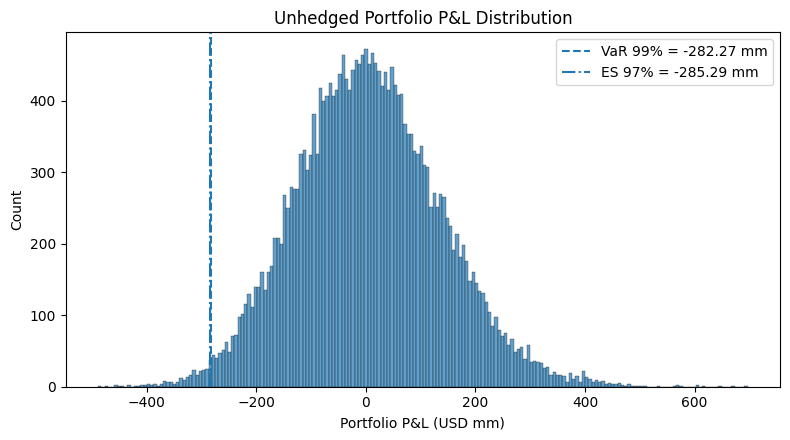

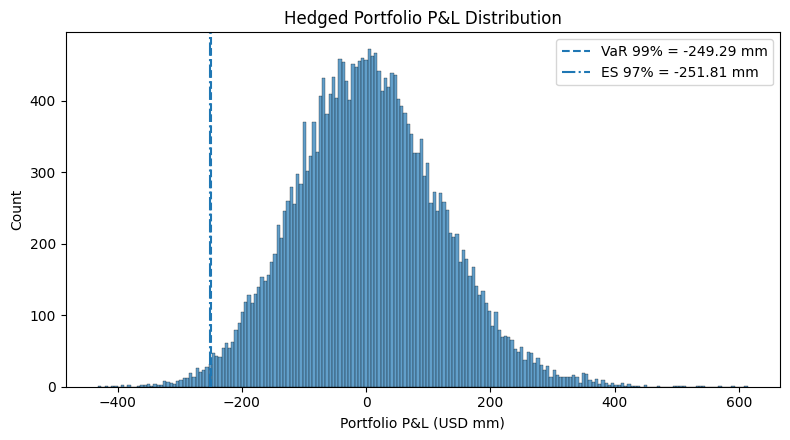

In [13]:
def plot_pnl_dist(pnl, title, conf_var=CONF_VAR, conf_es=CONF_ES):
    fig, ax = plt.subplots(figsize=(8, 4.5))
    sns.histplot(pnl/1e6, bins=200, ax=ax, alpha=0.7)  # in $mm
    q_var = np.quantile(pnl, 1-conf_var)/1e6
    q_es  = np.quantile(pnl, 1-conf_es)/1e6
    es_mean = pnl[pnl <= np.quantile(pnl, 1-conf_es)].mean()/1e6
    ax.axvline(q_var, linestyle="--", linewidth=1.5, label=f"VaR {int(conf_var*100)}% = {q_var:.2f} mm")
    ax.axvline(es_mean, linestyle="-.", linewidth=1.5, label=f"ES {int(conf_es*100)}% = {es_mean:.2f} mm")
    ax.set_title(title)
    ax.set_xlabel("Portfolio P&L (USD mm)")
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_pnl_dist(pnl_unhedged, "Unhedged Portfolio P&L Distribution")
plot_pnl_dist(pnl_hedged,   "Hedged Portfolio P&L Distribution")

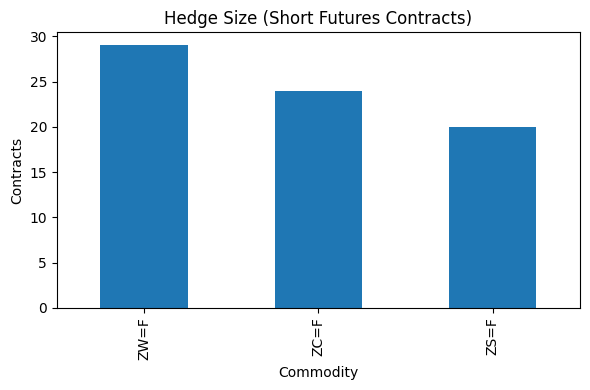

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))
hedge_series.sort_values(ascending=False).plot(kind="bar", ax=ax)
ax.set_title("Hedge Size (Short Futures Contracts)")
ax.set_ylabel("Contracts")
ax.set_xlabel("Commodity")
plt.tight_layout()
plt.show()

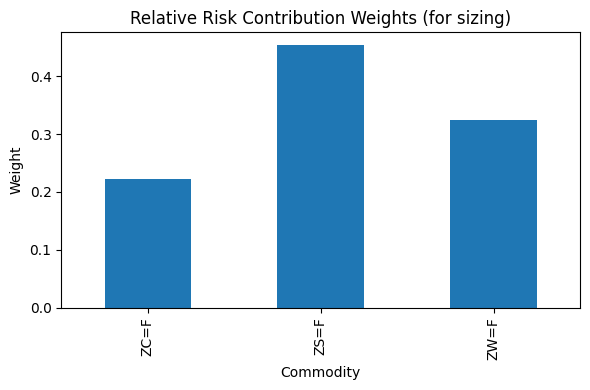

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))
(pd.Series(contrib, index=prices_fut.columns) / (contrib.sum()+1e-12)).plot(kind="bar", ax=ax)
ax.set_title("Relative Risk Contribution Weights (for sizing)")
ax.set_ylabel("Weight")
ax.set_xlabel("Commodity")
plt.tight_layout()
plt.show()

SIMPLE STRESSES (USD P&L)
Price_-20%: -393050000.0
Price_-40%: -786100000.0


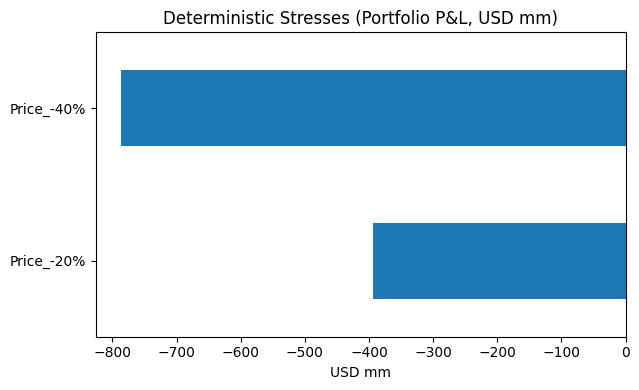

In [16]:
def stress_pnl(price_drop_pct):
    end_prices = last_cash * (1 - price_drop_pct)
    pnl = (end_prices.values * qty_vec - last_cash.values * qty_vec).sum()
    return pnl

stresses = {
    "Price_-20%": stress_pnl(0.20),
    "Price_-40%": stress_pnl(0.40),
}
print("SIMPLE STRESSES (USD P&L)")
for k, v in stresses.items():
    print(f"{k}: {round(v,2)}")


stress_df = pd.Series(stresses).sort_index()
fig, ax = plt.subplots(figsize=(6.5, 4))
(stress_df/1e6).plot(kind="barh", ax=ax)
ax.set_title("Deterministic Stresses (Portfolio P&L, USD mm)")
ax.set_xlabel("USD mm")
plt.tight_layout()
plt.show()


find the futures price in Argentine pesos

In [17]:


TICKERS = ["ZC=F", "ZS=F", "ZW=F"]
START = "2014-01-01"
END = None
USE_BASIS = False
BASIS_USD_PER_BU = {"ZC=F": 0.00, "ZS=F": 0.00, "ZW=F": 0.00}

EXPOSURE_BUSHELS = {"ZC=F": 1_000_000, "ZS=F": 1_000_000, "ZW=F": 1_000_000}

HORIZON_DAYS = 20
N_PATHS = 25_000
DIST = "student_t"
T_DF = 6
CONF_VAR = 0.99
CONF_ES = 0.975
CFAR_TARGET_FRACTION = 0.20
FUT_CONTRACT_SIZE = 5_000.0

# --- Download futures (USD/bu) ---
data = yf.download(TICKERS, start=START, end=END, progress=False, auto_adjust=False)
prices_fut = data["Close"].dropna(how="all")  # USD/bu
if isinstance(prices_fut, pd.Series):
    prices_fut = prices_fut.to_frame()

# --- Download daily FX: USD/BRL (BRL per USD) ---
fx_df = yf.download("BRL=X", start=START, end=END, progress=False, auto_adjust=False)

# Ensure we have a Series of closing prices
if isinstance(fx_df, pd.DataFrame) and "Close" in fx_df.columns:
    fx = fx_df["Close"]
else:
    # Fallback: squeeze to Series, then pick the first column if still DataFrame
    fx = fx_df.squeeze()
    if isinstance(fx, pd.DataFrame):
        fx = fx.iloc[:, 0]

fx = fx.astype(float)
fx.name = "USDBRL"  # set name directly to avoid rename() issues

# Align FX to futures calendar
fx = fx.reindex(prices_fut.index).ffill()

# --- Build USD cash series, then convert day-by-day to BRL ---
if USE_BASIS:
    basis_usd = pd.DataFrame({t: BASIS_USD_PER_BU.get(t, 0.0) for t in TICKERS}, index=prices_fut.index)
    prices_cash_usd = (prices_fut + basis_usd).dropna(how="any", axis=0)
else:
    prices_cash_usd = prices_fut.copy()



In [18]:


# --- Normalize both indexes: datelike, no time, no tz
def _normalize_idx(idx):
    idx = pd.to_datetime(idx, utc=False)             # cast to datetime (naive)
    if getattr(idx, "tz", None) is not None:         # drop tz if present
        idx = idx.tz_convert(None) if hasattr(idx, "tz_convert") else idx.tz_localize(None)
    return pd.DatetimeIndex(idx.date)                # strip time-of-day

prices_cash_usd = prices_cash_usd.copy()
fx = fx.copy()

prices_cash_usd.index = _normalize_idx(prices_cash_usd.index)
fx.index = _normalize_idx(fx.index)

# Align FX to futures calendar; fill gaps due to different trading days
fx_aligned = fx.reindex(prices_cash_usd.index).ffill().bfill()



prices_cash_brl = prices_cash_usd.mul(fx_aligned, axis=0)


if prices_cash_brl.isna().all().all():
    prices_cash_brl = prices_cash_usd.mul(fx_aligned.values, axis=0)



In [19]:
prices_cash_brl.head()

Ticker,ZC=F,ZS=F,ZW=F
2014-01-02,991.160554,3033.587713,1407.188706
2014-01-03,1009.920475,3074.474552,1444.532061
2014-01-06,1014.409132,3075.242645,1436.536134
2014-01-07,1011.196159,3084.623025,1430.154192
2014-01-08,987.747911,3081.086561,1394.572141


In [20]:
returns_in_brl = np.log(prices_cash_brl / prices_cash_brl.shift(1)).dropna()
print("DESCRIPTIVE STATS (daily log returns x 1e2 %)")
desc = (returns_in_brl * 100).describe().T
desc["skew"] = (returns_in_brl * 100).skew()
desc["kurtosis_excess"] = (returns_in_brl * 100).kurtosis()
print(desc.round(3))

DESCRIPTIVE STATS (daily log returns x 1e2 %)
         count   mean    std     min    25%    50%    75%     max   skew  \
Ticker                                                                     
ZC=F    2962.0  0.028  1.894 -20.908 -1.067  0.019  1.121   9.010 -0.788   
ZS=F    2962.0  0.021  1.675 -12.697 -0.958  0.015  1.016   8.535 -0.386   
ZW=F    2962.0  0.022  2.185 -12.014 -1.341 -0.104  1.330  18.483  0.351   

        kurtosis_excess  
Ticker                   
ZC=F              9.684  
ZS=F              3.859  
ZW=F              2.718  


In [22]:
print("NORMALITY: Jarque–Bera p-values")
jb_rows = []
for c in returns_in_brl.columns:
    stat, p = jarque_bera(returns_in_brl[c].dropna())
    jb_rows.append((c, p))
print(pd.DataFrame(jb_rows, columns=["asset", "JB_pval"]).set_index("asset").round(4))

NORMALITY: Jarque–Bera p-values
       JB_pval
asset         
ZC=F       0.0
ZS=F       0.0
ZW=F       0.0


In [23]:
print("AUTOCORRELATION (Ljung–Box p-values at lags 5, 20)")
lb_rows = []
for c in returns_in_brl.columns:
    lb5 = acorr_ljungbox(returns_in_brl[c].dropna(), lags=[5], return_df=True)["lb_pvalue"].iloc[0]
    lb20 = acorr_ljungbox(returns_in_brl[c].dropna(), lags=[20], return_df=True)["lb_pvalue"].iloc[0]
    lb_rows.append((c, lb5, lb20))
print(pd.DataFrame(lb_rows, columns=["asset", "LB_p(5)", "LB_p(20)"]).set_index("asset").round(4))


AUTOCORRELATION (Ljung–Box p-values at lags 5, 20)
       LB_p(5)  LB_p(20)
asset                   
ZC=F     0.000    0.0065
ZS=F     0.000    0.0000
ZW=F     0.047    0.0710


In [24]:
print("CORRELATION MATRIX (daily returns)")
print(returns_in_brl.corr().round(3))

print("ROLLING VOL (21d, annualized %)")
roll_vol = returns_in_brl.rolling(21).std() * np.sqrt(252) * 100
print(roll_vol.iloc[-1].round(2))


CORRELATION MATRIX (daily returns)
Ticker   ZC=F   ZS=F   ZW=F
Ticker                     
ZC=F    1.000  0.675  0.641
ZS=F    0.675  1.000  0.507
ZW=F    0.641  0.507  1.000
ROLLING VOL (21d, annualized %)
Ticker
ZC=F    17.06
ZS=F    18.84
ZW=F    21.01
Name: 2025-10-17 00:00:00, dtype: float64


In [25]:
print("TAIL CHECK: Empirical vs Gaussian 1% loss (in % return points)")
tail_rows = []
for c in returns_in_brl.columns:
    r = returns_in_brl[c].dropna()
    emp_q = np.quantile(r, 0.01) * 100
    mu, sig = r.mean(), r.std()
    gauss_q = (mu + sig * np.quantile(np.random.normal(size=1_000_000), 0.01)) * 100
    tail_rows.append((c, emp_q, gauss_q))
print(pd.DataFrame(tail_rows, columns=["asset", "empirical_1pct", "gaussian_1pct"]).set_index("asset").round(3))

TAIL CHECK: Empirical vs Gaussian 1% loss (in % return points)
       empirical_1pct  gaussian_1pct
asset                               
ZC=F           -4.760         -4.364
ZS=F           -4.258         -3.878
ZW=F           -5.112         -5.070


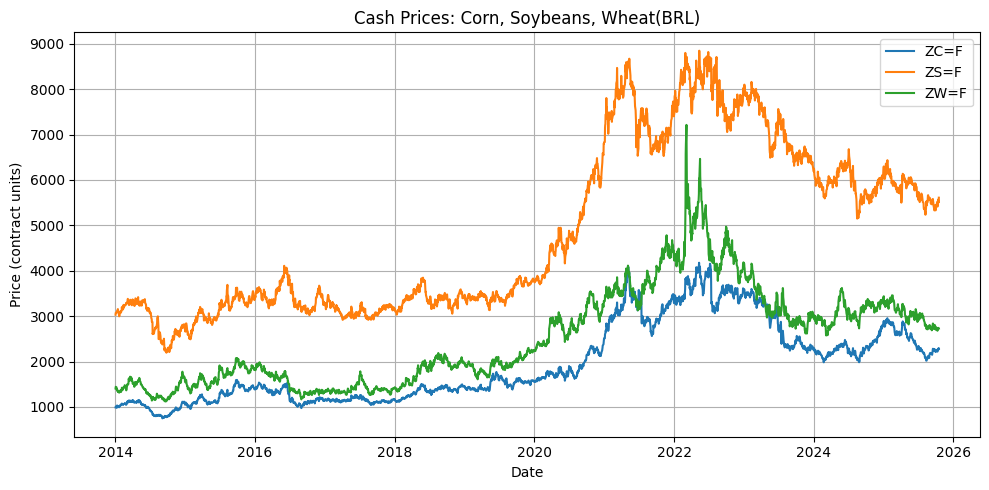

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
for t in TICKERS:
    plt.plot(prices_cash_brl.index, prices_cash_brl[t])
plt.title("Cash Prices: Corn, Soybeans, Wheat(BRL)")
plt.xlabel("Date")
plt.ylabel("Price (contract units)")
plt.grid(True)
plt.legend(TICKERS)
plt.tight_layout()
plt.show()

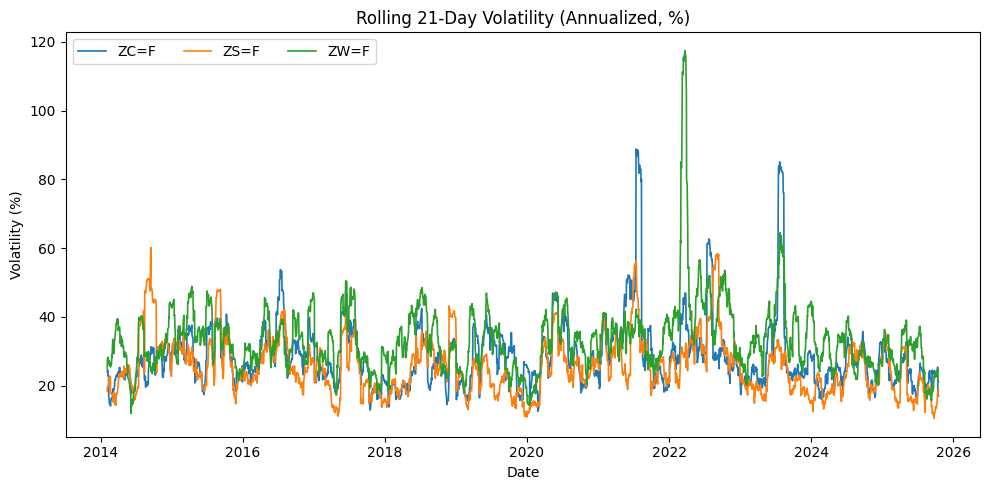

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))
rv = returns_in_brl.rolling(21).std() * (252**0.5) * 100
for c in rv.columns:
    ax.plot(rv.index, rv[c], label=c, linewidth=1.2)
ax.set_title("Rolling 21-Day Volatility (Annualized, %)")
ax.set_xlabel("Date")
ax.set_ylabel("Volatility (%)")
ax.legend(ncol=len(rv.columns))
plt.tight_layout()
plt.show()

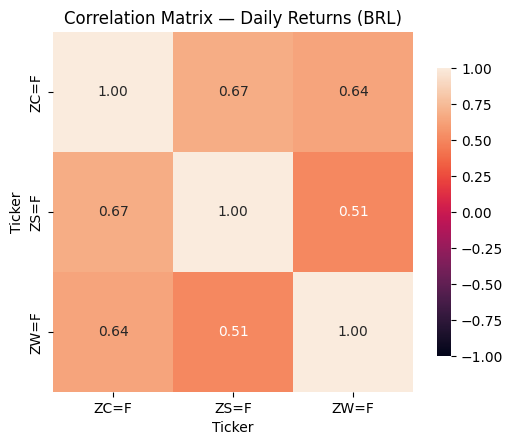

In [29]:
fig, ax = plt.subplots(figsize=(5.5, 4.5))
corr = returns_in_brl.corr()
sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1, vmax=1, square=True, ax=ax, cbar_kws={"shrink":0.8})
ax.set_title("Correlation Matrix — Daily Returns (BRL)")
plt.tight_layout()
plt.show()

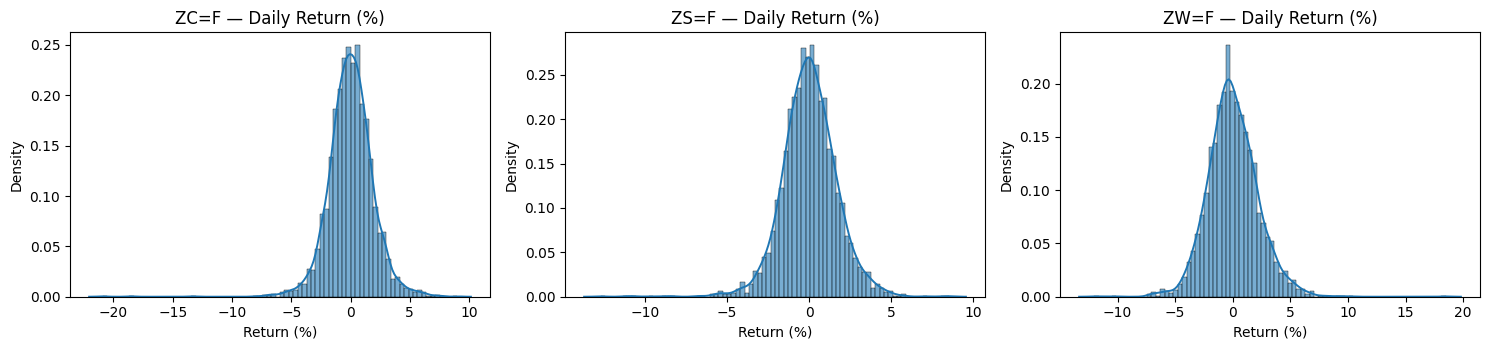

In [30]:
cols = returns_in_brl.columns.tolist()
n = len(cols)
rows = 1 if n <= 3 else int(np.ceil(n/2))
cols_per_row = min(3, n)
fig, axes = plt.subplots(rows, cols_per_row, figsize=(5*cols_per_row, 3.6*rows))
axes = np.atleast_1d(axes).ravel()

for i, name in enumerate(cols):
    r = returns_in_brl[name].dropna() * 100  # %
    sns.histplot(r, bins=80, stat="density", ax=axes[i], alpha=0.6)
    sns.kdeplot(r, ax=axes[i], linewidth=1.4)
    axes[i].set_title(f"{name} — Daily Return (%)")
    axes[i].set_xlabel("Return (%)"); axes[i].set_ylabel("Density")
for j in range(i+1, len(axes)):
    axes[j].axis("off")
plt.tight_layout()
plt.show()

In [31]:
mu = returns_in_brl.mean().values
cov = returns_in_brl.cov().values

w, V = eigh((cov + cov.T) / 2.0)
w[w < 1e-10] = 1e-10
cov_psd = (V @ np.diag(w) @ V.T)
L = cholesky(cov_psd)

if DIST.lower() == "gaussian":
    Z = np.random.normal(size=(N_PATHS, HORIZON_DAYS, len(mu)))
else:
    g = np.random.gamma(T_DF/2.0, 2.0/T_DF, size=(N_PATHS, HORIZON_DAYS))
    Z = np.random.normal(size=(N_PATHS, HORIZON_DAYS, len(mu))) / np.sqrt(g)[:, :, None]

dR = (Z @ L.T) + mu
R_h = dR.sum(axis=1)

In [32]:
last_cash = prices_cash_brl.iloc[-1]
tickers = list(last_cash.index)
qty_vec = np.array([EXPOSURE_BUSHELS.get(t, 0.0) for t in tickers])

price_end = {}
for i, t in enumerate(tickers):
    price_end[t] = last_cash[t] * np.exp(R_h[:, i])
price_end = pd.DataFrame(price_end)  # paths x assets

start_val = last_cash.values * qty_vec
end_val = price_end.values * qty_vec
pnl_unhedged = (end_val - start_val).sum(axis=1)

alpha_var = 1 - CONF_VAR
q_var = np.quantile(pnl_unhedged, alpha_var)
VaR_u = -q_var
alpha_es = 1 - CONF_ES
q_es = np.quantile(pnl_unhedged, alpha_es)
ES_u = -pnl_unhedged[pnl_unhedged <= q_es].mean()

print("UNHEDGED RISK (ARS)")
print({"VaR_%": int(CONF_VAR*100), "VaR_ARS": round(VaR_u, 2),
       "ES_%": int(CONF_ES*100), "ES_ARS": round(ES_u, 2)})

target_cfar_usd = CFAR_TARGET_FRACTION * VaR_u

sigma_h = R_h.std(axis=0)
risk_notional = last_cash.values * qty_vec
contrib = np.abs(risk_notional * sigma_h)
w_contrib = contrib / (contrib.sum() + 1e-12)

reduction_needed = max(VaR_u - target_cfar_usd, 0.0)
per_asset_reduction = w_contrib * reduction_needed
contract_brl = FUT_CONTRACT_SIZE * prices_cash_brl.iloc[-1].values
hedge_contracts = np.round(per_asset_reduction / (contract_brl + 1e-12)).astype(int)

hedge_series = pd.Series(hedge_contracts, index=tickers)
print("HEDGE CONTRACTS (short futures, + = more short)")
print(hedge_series)

fut_last = prices_cash_brl.iloc[-1]
fut_end = {}
for i, t in enumerate(tickers):
    fut_end[t] = fut_last[t] * np.exp(R_h[:, i])
fut_end = pd.DataFrame(fut_end)

dP = fut_end.values - fut_last.values
mtm = -(dP * (FUT_CONTRACT_SIZE * hedge_contracts))   # short futures MTM
pnl_hedged = pnl_unhedged + mtm.sum(axis=1)

q_var_h = np.quantile(pnl_hedged, alpha_var)
VaR_h = -q_var_h
q_es_h = np.quantile(pnl_hedged, alpha_es)
ES_h = -pnl_hedged[pnl_hedged <= q_es_h].mean()

print("HEDGED RISK (ARS)")
print({"VaR_%": int(CONF_VAR*100), "VaR_ARS": round(VaR_h, 2),
       "ES_%": int(CONF_ES*100), "ES_ARS": round(ES_h, 2),
       "VaR_Reduction_%": round(100*(1 - VaR_h/max(VaR_u,1e-9)), 2)})

UNHEDGED RISK (ARS)
{'VaR_%': 99, 'VaR_ARS': np.float64(1921541493.49), 'ES_%': 97, 'ES_ARS': np.float64(1932239903.93)}
HEDGE CONTRACTS (short futures, + = more short)
ZC=F    29
ZS=F    26
ZW=F    34
dtype: int64
HEDGED RISK (ARS)
{'VaR_%': 99, 'VaR_ARS': np.float64(1644975944.79), 'ES_%': 97, 'ES_ARS': np.float64(1653660378.37), 'VaR_Reduction_%': np.float64(14.39)}


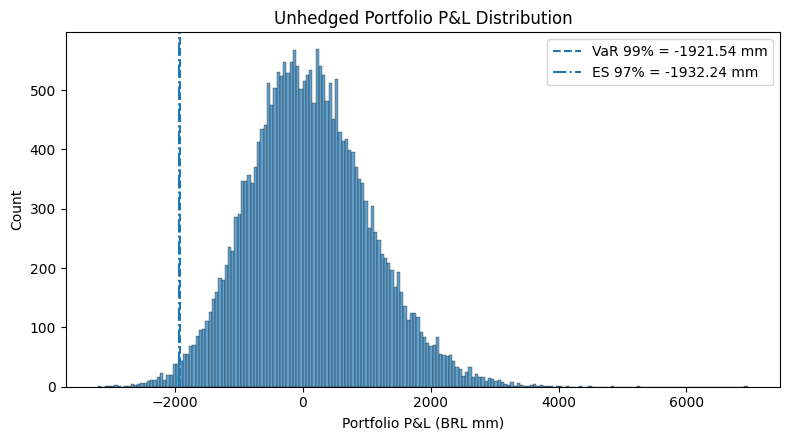

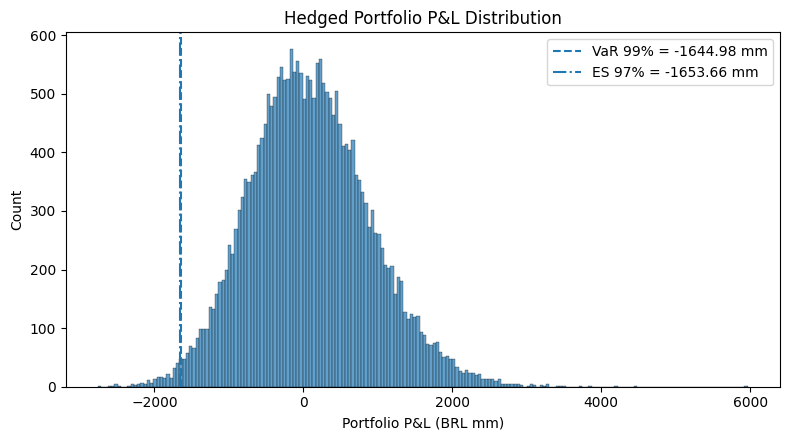

In [33]:
def plot_pnl_dist(pnl, title, conf_var=CONF_VAR, conf_es=CONF_ES):
    fig, ax = plt.subplots(figsize=(8, 4.5))
    sns.histplot(pnl/1e6, bins=200, ax=ax, alpha=0.7)  # in $mm
    q_var = np.quantile(pnl, 1-conf_var)/1e6
    q_es  = np.quantile(pnl, 1-conf_es)/1e6
    es_mean = pnl[pnl <= np.quantile(pnl, 1-conf_es)].mean()/1e6
    ax.axvline(q_var, linestyle="--", linewidth=1.5, label=f"VaR {int(conf_var*100)}% = {q_var:.2f} mm")
    ax.axvline(es_mean, linestyle="-.", linewidth=1.5, label=f"ES {int(conf_es*100)}% = {es_mean:.2f} mm")
    ax.set_title(title)
    ax.set_xlabel("Portfolio P&L (BRL mm)")
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_pnl_dist(pnl_unhedged, "Unhedged Portfolio P&L Distribution")
plot_pnl_dist(pnl_hedged,   "Hedged Portfolio P&L Distribution")

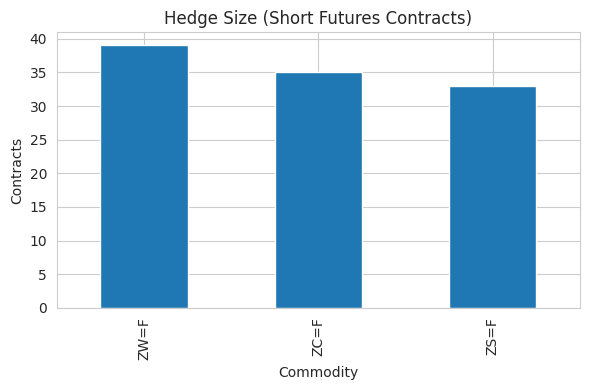

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
hedge_series.sort_values(ascending=False).plot(kind="bar", ax=ax)
ax.set_title("Hedge Size (Short Futures Contracts)")
ax.set_ylabel("Contracts")
ax.set_xlabel("Commodity")
plt.tight_layout()
plt.show()

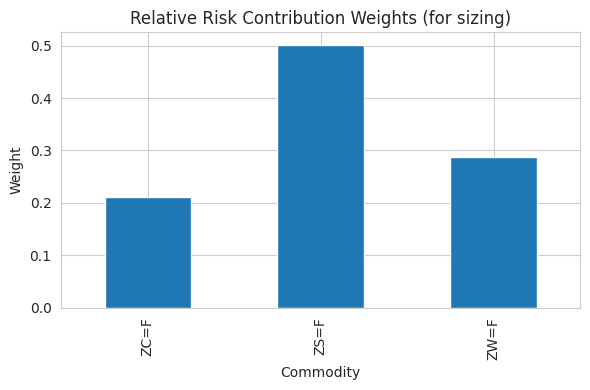

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
(pd.Series(contrib, index=prices_fut.columns) / (contrib.sum()+1e-12)).plot(kind="bar", ax=ax)
ax.set_title("Relative Risk Contribution Weights (for sizing)")
ax.set_ylabel("Weight")
ax.set_xlabel("Commodity")
plt.tight_layout()
plt.show()

SIMPLE STRESSES (USD P&L)
Price_-20%: -2124553220.18
Price_-40%: -4249106440.35


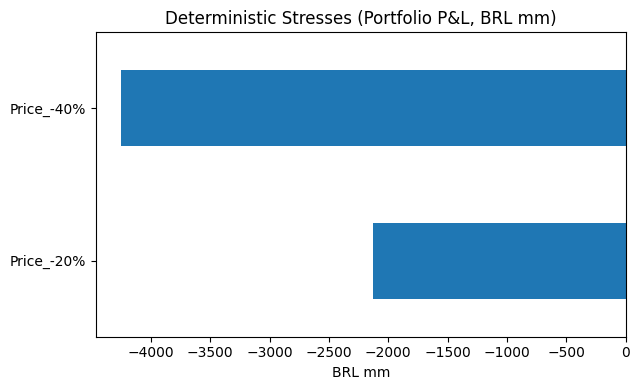

In [34]:
def stress_pnl(price_drop_pct):
    end_prices = last_cash * (1 - price_drop_pct)
    pnl = (end_prices.values * qty_vec - last_cash.values * qty_vec).sum()
    return pnl

stresses = {
    "Price_-20%": stress_pnl(0.20),
    "Price_-40%": stress_pnl(0.40),
}
print("SIMPLE STRESSES (USD P&L)")
for k, v in stresses.items():
    print(f"{k}: {round(v,2)}")


stress_df = pd.Series(stresses).sort_index()
fig, ax = plt.subplots(figsize=(6.5, 4))
(stress_df/1e6).plot(kind="barh", ax=ax)
ax.set_title("Deterministic Stresses (Portfolio P&L, BRL mm)")
ax.set_xlabel("BRL mm")
plt.tight_layout()
plt.show()
